## Assignment 2: Overview

#### PART 1

1. Implement 3 Local Random Search Algorithms
    - Randomized Hill Climbing
    - Simulated Annealing
    - A Generative Algorithm

2. Create 2 Optimization Problems
    - Continuous Peaks 
    - Max K-Coloring Problem

3. Apply each of the 3 Search Algos to both the problems

4. Hypothesis: Simulated Annealing > RHC for Cont. Peaks and GA > RHC for Max K Coloring

5. Tune Each Algorithm with 2 Hyperparams; Show results of the Hyperparam independently.



#### PART 2

1. Use the 3 Algos instead of Backprop in a NN for Telco Dataset


In [9]:
import sys
import six
sys.modules['sklearn.externals.six'] = six
import mlrose as mlrose
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def n_queens_max_fitness(state):
    """
    Calculate the number of non-attacking pairs of queens for the N Queens problem.
    This is a maximization problem where higher fitness is better.
    """
    n = len(state)
    total_pairs = n * (n - 1) / 2  # Total number of possible pairs
    attacking_pairs = 0

    # Count the number of attacking pairs
    for i in range(n):
        for j in range(i + 1, n):
            # Check for same row or diagonal attacks
            if state[i] == state[j] or abs(state[i] - state[j]) == j - i:
                attacking_pairs += 1

    # Fitness is total non-attacking pairs
    return total_pairs - attacking_pairs


def setup_n_queens(n=16):
    """Setup the N-Queens problem."""
    fitness_cust = mlrose.CustomFitness(n_queens_max_fitness)
    problem = mlrose.DiscreteOpt(length=n, fitness_fn=fitness_cust, maximize=True, max_val=n)
    return problem

In [13]:
def solve_with_rhc(problem):
    # Solve using Randomized Hill Climbing with curve tracking
    best_state, best_fitness, fitness_curve = mlrose.random_hill_climb(problem,
                                                                        max_attempts=10,
                                                                        max_iters=1000,
                                                                        restarts=5,
                                                                        random_state=1,
                                                                        curve=True)
    return best_state, best_fitness, fitness_curve

def solve_with_sa(problem):
    # Define decay schedule
    schedule = mlrose.ExpDecay()
    # Solve using Simulated Annealing with curve tracking
    best_state, best_fitness, fitness_curve = mlrose.simulated_annealing(problem,
                                                                        schedule=schedule,
                                                                        max_attempts=10,
                                                                        max_iters=1000,
                                                                        random_state=1,
                                                                        curve=True)
    return best_state, best_fitness, fitness_curve

def solve_with_ga(problem):
    # Solve using Genetic Algorithm with curve tracking
    best_state, best_fitness, fitness_curve = mlrose.genetic_alg(problem,
                                                                pop_size=200,
                                                                mutation_prob=0.1,
                                                                max_attempts=10,
                                                                max_iters=1000,
                                                                random_state=1,
                                                                curve=True)
    return best_state, best_fitness, fitness_curve


In [16]:
def plot_fitness_curves(rhc_curve, sa_curve, ga_curve):
    plt.figure(figsize=(10, 6))
    plt.plot(rhc_curve, label='Randomized Hill Climbing', color='red')
    plt.plot(sa_curve, label='Simulated Annealing', color='blue')
    plt.plot(ga_curve, label='Genetic Algorithm', color='green')
    plt.title('Fitness Curves for N Queens Problem')
    plt.xlabel('Iterations')
    plt.ylabel('Fitness (Higher is better)')
    plt.legend()
    plt.grid(True)
    plt.show()


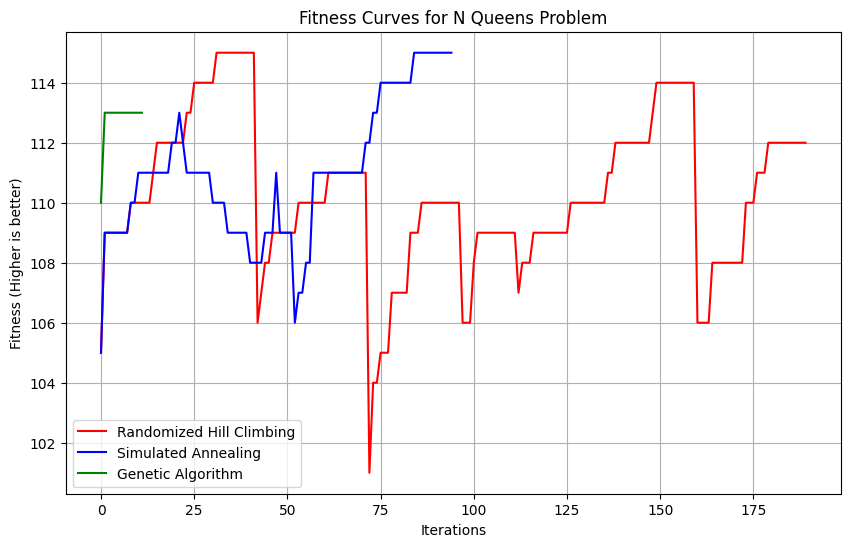

RHC solution (maximized fitness): [ 5 11  4  6 15  9 10  8 15  2  0  1 12  7 13 14] with fitness: 115.0
SA solution (maximized fitness): [ 6 11 15  0  4 14 10  8  4  1 13  8  2 12  7  9] with fitness: 115.0
GA solution (maximized fitness): [ 8  4  2  0  1 12  5  5 13  4 14  0 14  6 15  7] with fitness: 113.0


In [17]:

problem = setup_n_queens(n=16)
# Solve the problem using different algorithms and get fitness curves
rhc_state, rhc_fitness, rhc_curve = solve_with_rhc(problem)
sa_state, sa_fitness, sa_curve = solve_with_sa(problem)
ga_state, ga_fitness, ga_curve = solve_with_ga(problem)

# Plot the fitness curves (higher fitness is better here)
plot_fitness_curves(rhc_curve, sa_curve, ga_curve)

print("RHC solution (maximized fitness):", rhc_state, "with fitness:", rhc_fitness)
print("SA solution (maximized fitness):", sa_state, "with fitness:", sa_fitness)
print("GA solution (maximized fitness):", ga_state, "with fitness:", ga_fitness)


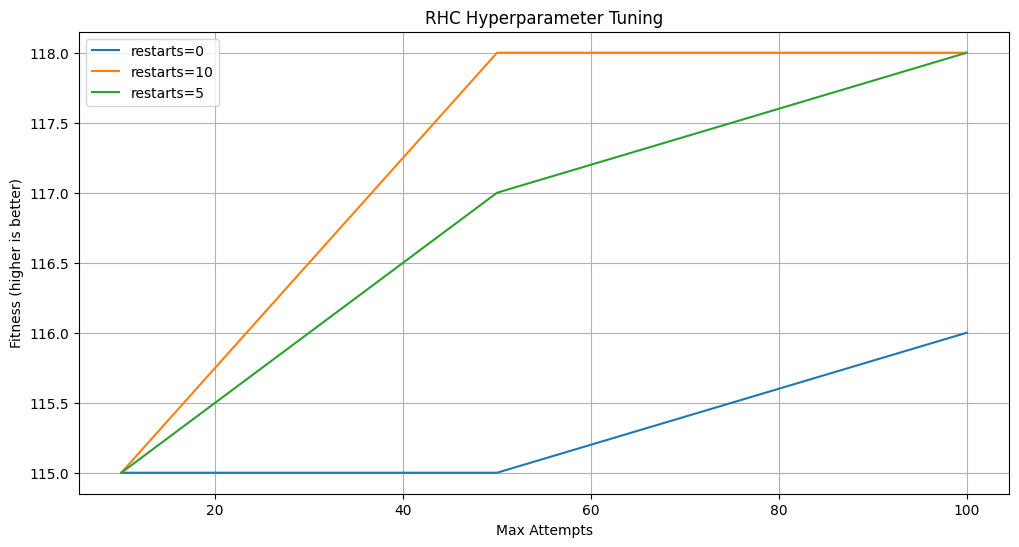

In [21]:
def tune_rhc(problem):
    attempts = [10, 50, 100]
    restarts = [0, 5, 10]
    results = []

    for attempt in attempts:
        for restart in restarts:
            _, fitness, _ = mlrose.random_hill_climb(problem,
                                                    max_attempts=attempt,
                                                    max_iters=1000,
                                                    restarts=restart,
                                                    random_state=1,
                                                    curve=True)
            results.append((attempt, restart, fitness))
    
    return results

def plot_rhc_tuning(results):
    attempts, restarts, fitnesses = zip(*results)
    plt.figure(figsize=(12, 6))
    for restart in set(restarts):
        subset = [(a, f) for a, r, f in results if r == restart]
        subset_attempts, subset_fitnesses = zip(*subset)
        plt.plot(subset_attempts, subset_fitnesses, label=f'restarts={restart}')
    
    plt.title('RHC Hyperparameter Tuning')
    plt.xlabel('Max Attempts')
    plt.ylabel('Fitness (higher is better)')
    plt.legend()
    plt.grid(True)
    plt.show()

problem = setup_n_queens(16)
rhc_results = tune_rhc(problem)
plot_rhc_tuning(rhc_results)


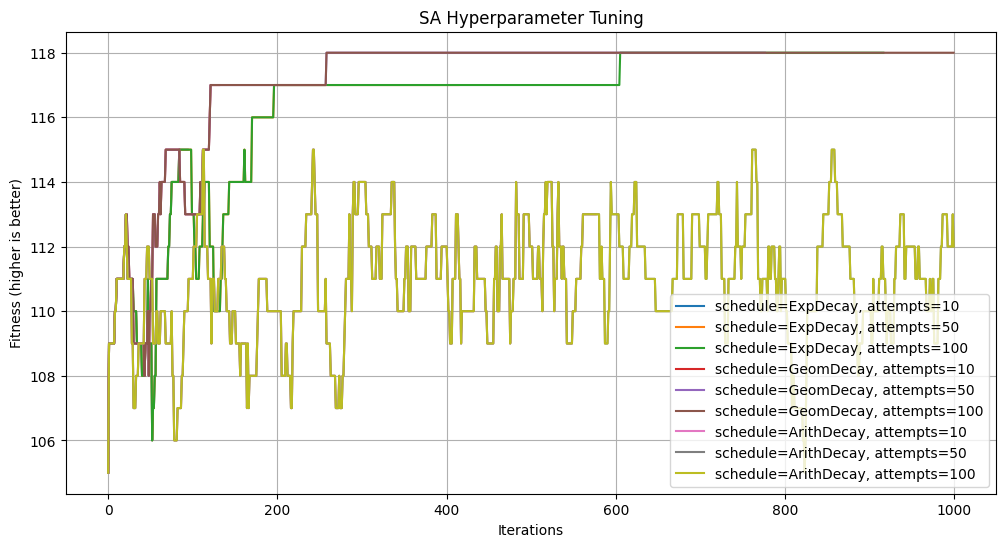

In [23]:
def tune_sa(problem):
    schedules = {'ExpDecay': mlrose.ExpDecay(), 'GeomDecay': mlrose.GeomDecay(), 'ArithDecay': mlrose.ArithDecay()}
    attempts = [10, 50, 100]
    results = []

    for schedule_name, schedule in schedules.items():
        for attempt in attempts:
            _, fitness, fitness_curve = mlrose.simulated_annealing(problem,
                                                                schedule=schedule,
                                                                max_attempts=attempt,
                                                                max_iters=1000,
                                                                random_state=1,
                                                                curve=True)
            results.append((schedule_name, attempt, fitness, fitness_curve))
    
    return results

def plot_sa_tuning(results):
    plt.figure(figsize=(12, 6))
    for schedule_name, attempt, fitness, fitness_curve in results:
        plt.plot(fitness_curve, label=f'schedule={schedule_name}, attempts={attempt}')
    
    plt.title('SA Hyperparameter Tuning')
    plt.xlabel('Iterations')
    plt.ylabel('Fitness (higher is better)')
    plt.legend()
    plt.grid(True)
    plt.show()

problem = setup_n_queens(16)
sa_results = tune_sa(problem)
plot_sa_tuning(sa_results)


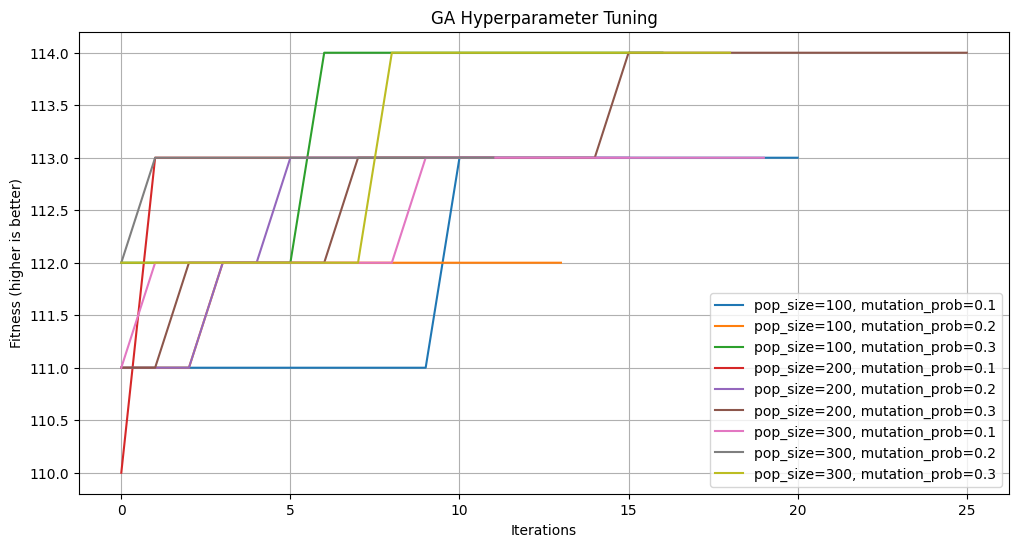

In [29]:
def tune_ga(problem):
    pop_sizes = [100, 200, 300]
    mutation_probs = [0.1, 0.2, 0.3]
    attempts = [10, 50, 100]
    results = []

    for pop_size in pop_sizes:
        for mutation_prob in mutation_probs:
            
                _, fitness, fitness_curve = mlrose.genetic_alg(problem,
                                                                     pop_size=pop_size,
                                                                     mutation_prob=mutation_prob,
                                                                     max_iters=1000,
                                                                     random_state=1,
                                                                     curve=True)
                results.append((pop_size, mutation_prob, fitness, fitness_curve))
    
    return results

def plot_ga_tuning(results):
    plt.figure(figsize=(12, 6))
    for pop_size, mutation_prob, fitness, fitness_curve in results:
        plt.plot(fitness_curve, label=f'pop_size={pop_size}, mutation_prob={mutation_prob}')
    
    plt.title('GA Hyperparameter Tuning')
    plt.xlabel('Iterations')
    plt.ylabel('Fitness (higher is better)')
    plt.legend()
    plt.grid(True)
    plt.show()

problem = setup_n_queens(16)
ga_results = tune_ga(problem)
plot_ga_tuning(ga_results)


## 4 Peaks Problem

In [30]:
def four_peaks_fitness(state, T):
    n = len(state)
    R = np.argmax(state == 0) if 0 in state else n
    L = np.argmax(state[::-1] == 1) if 1 in state[::-1] else n
    if R > T and L > T:
        return max(T + R, T + L)
    else:
        return max(R, L)


In [31]:
def setup_four_peaks(n=40, T=20):
    fitness_cust = mlrose.CustomFitness(lambda state: four_peaks_fitness(state, T))
    problem = mlrose.DiscreteOpt(length=n, fitness_fn=fitness_cust, maximize=True, max_val=2)
    return problem


In [37]:
# Tuning and plotting functions for RHC, SA, and GA
def tune_rhc(problem):
    attempts = [10, 50, 100]
    restarts = [0, 5, 10]
    results = []

    for attempt in attempts:
        for restart in restarts:
            _, fitness, fitness_curve = mlrose.random_hill_climb(problem,
                                                                       max_attempts=attempt,
                                                                       max_iters=1000,
                                                                       restarts=restart,
                                                                       random_state=1,
                                                                       curve=True)
            results.append((attempt, restart, fitness, fitness_curve))
    
    return results

def plot_rhc_tuning(results):
    plt.figure(figsize=(12, 6))
    for attempt, restart, fitness, fitness_curve in results:
        plt.plot(fitness_curve, label=f'attempts={attempt}, restarts={restart}')
    
    plt.title('RHC Hyperparameter Tuning for 4 Peaks')
    plt.xlabel('Iterations')
    plt.ylabel('Fitness (higher is better)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [38]:
def tune_sa(problem):
    schedules = {'ExpDecay': mlrose.ExpDecay(), 'GeomDecay': mlrose.GeomDecay(), 'ArithDecay': mlrose.ArithDecay()}
    attempts = [10, 50, 100]
    results = []

    for schedule_name, schedule in schedules.items():
        for attempt in attempts:
            _, fitness, fitness_curve = mlrose.simulated_annealing(problem,
                                                                         schedule=schedule,
                                                                         max_attempts=attempt,
                                                                         max_iters=1000,
                                                                         random_state=1,
                                                                         curve=True)
            results.append((schedule_name, attempt, fitness, fitness_curve))
    
    return results

def plot_sa_tuning(results):
    plt.figure(figsize=(12, 6))
    for schedule_name, attempt, fitness, fitness_curve in results:
        plt.plot(fitness_curve, label=f'schedule={schedule_name}, attempts={attempt}')
    
    plt.title('SA Hyperparameter Tuning for 4 Peaks')
    plt.xlabel('Iterations')
    plt.ylabel('Fitness (higher is better)')
    plt.legend()
    plt.grid(True)
    plt.show()



In [73]:
def tune_ga(problem):
    pop_sizes = [5, 50, 100]
    mutation_probs = [0.01, 0.05, 0.1, 0.2, 0.3]
    attempts = [100,200,500]
    results = []

    for pop_size in pop_sizes:
        for mutation_prob in mutation_probs:
            for attempt in attempts:
                _, fitness, fitness_curve = mlrose.genetic_alg(problem,
                                                                     pop_size=pop_size,
                                                                     mutation_prob=mutation_prob,
                                                                     max_attempts=attempt,
                                                                     max_iters=1000,
                                                                     random_state=1,
                                                                     curve=True)
                results.append((pop_size, mutation_prob, attempt, fitness, fitness_curve))
    
    return results

def plot_ga_tuning(results):
    plt.figure(figsize=(12, 6))
    for pop_size, mutation_prob, attempt, fitness, fitness_curve in results:
        plt.plot(fitness_curve, label=f'pop_size={pop_size}, mutation_prob={mutation_prob}, attempts={attempt}')
    
    plt.title('GA Hyperparameter Tuning for One Max (Further Optimized)')
    plt.xlabel('Iterations')
    plt.ylabel('Fitness (higher is better)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)

    plt.show()



In [74]:
# Running the tuning and plotting for 4 Peaks problem
problem = setup_four_peaks(40, 20)



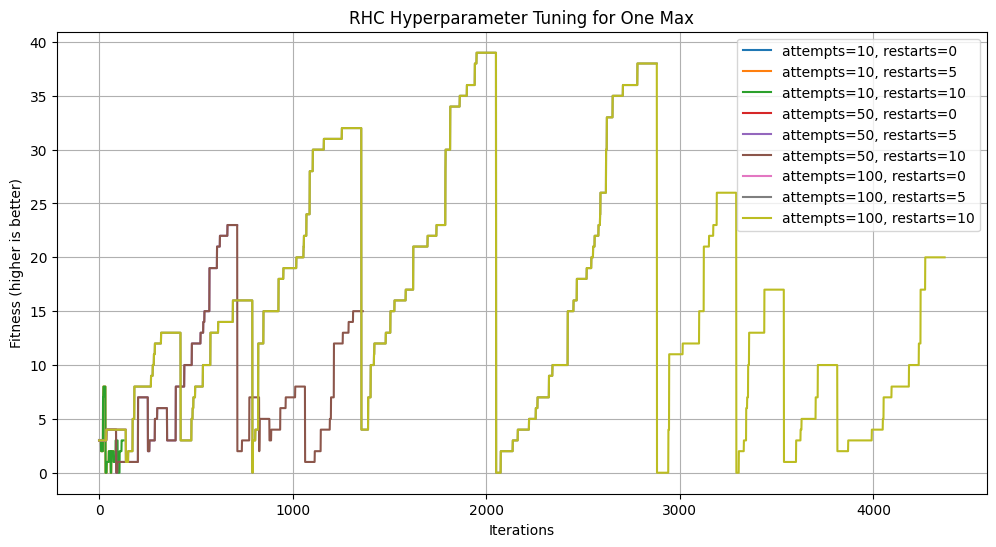

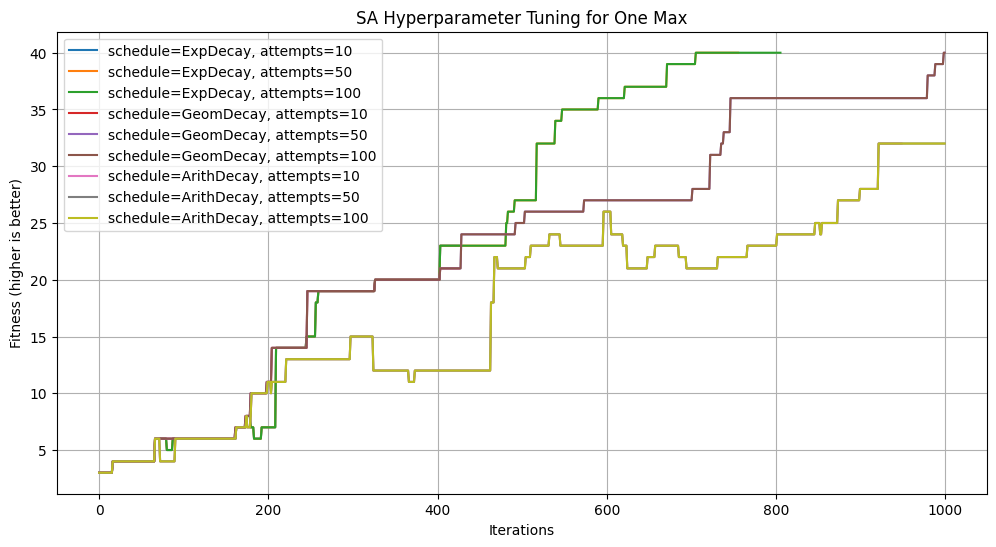

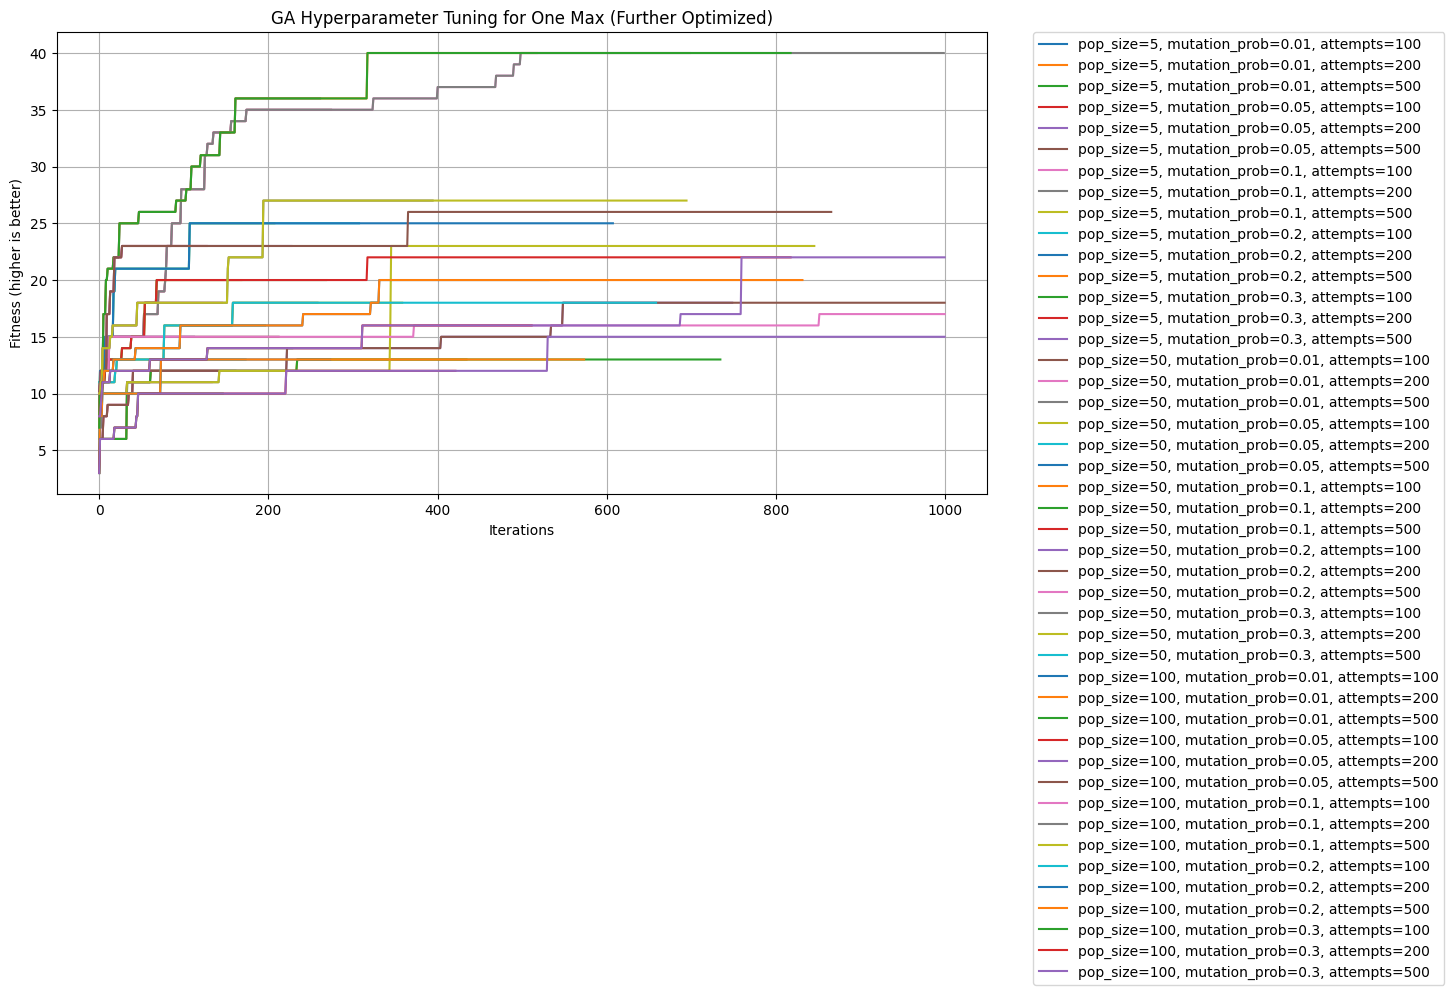

In [75]:
# RHC tuning
rhc_results = tune_rhc(problem)
plot_rhc_tuning(rhc_results)

# SA tuning
sa_results = tune_sa(problem)
plot_sa_tuning(sa_results)

# GA tuning
ga_results = tune_ga(problem)
plot_ga_tuning(ga_results)

## One Max Problem

In [42]:
def one_max_fitness(state):
    return sum(state)

In [43]:
def setup_one_max(n=40):
    fitness_cust = mlrose.CustomFitness(one_max_fitness)
    problem = mlrose.DiscreteOpt(length=n, fitness_fn=fitness_cust, maximize=True, max_val=2)
    return problem


In [53]:
# Tuning and plotting functions for RHC, SA, and GA
def tune_rhc(problem):
    attempts = [10, 50, 100]
    restarts = [0, 5, 10]
    results = []

    for attempt in attempts:
        for restart in restarts:
            _, fitness, fitness_curve = mlrose.random_hill_climb(problem,
                                                                       max_attempts=attempt,
                                                                       max_iters=1000,
                                                                       restarts=restart,
                                                                       random_state=1,
                                                                       curve=True)
            results.append((attempt, restart, fitness, fitness_curve))
    
    return results

def plot_rhc_tuning(results):
    plt.figure(figsize=(12, 6))
    for attempt, restart, fitness, fitness_curve in results:
        plt.plot(fitness_curve, label=f'attempts={attempt}, restarts={restart}')
    
    plt.title('RHC Hyperparameter Tuning for One Max')
    plt.xlabel('Iterations')
    plt.ylabel('Fitness (higher is better)')
    plt.legend()
    plt.grid(True)
    plt.show()

def tune_sa(problem):
    schedules = {'ExpDecay': mlrose.ExpDecay(), 'GeomDecay': mlrose.GeomDecay(), 'ArithDecay': mlrose.ArithDecay()}
    attempts = [10, 50, 100]
    results = []

    for schedule_name, schedule in schedules.items():
        for attempt in attempts:
            _, fitness, fitness_curve = mlrose.simulated_annealing(problem,
                                                                         schedule=schedule,
                                                                         max_attempts=attempt,
                                                                         max_iters=1000,
                                                                         random_state=1,
                                                                         curve=True)
            results.append((schedule_name, attempt, fitness, fitness_curve))
    
    return results

def plot_sa_tuning(results):
    plt.figure(figsize=(12, 6))
    for schedule_name, attempt, fitness, fitness_curve in results:
        plt.plot(fitness_curve, label=f'schedule={schedule_name}, attempts={attempt}')
    
    plt.title('SA Hyperparameter Tuning for One Max')
    plt.xlabel('Iterations')
    plt.ylabel('Fitness (higher is better)')
    plt.legend()
    plt.grid(True)
    plt.show()

def tune_ga(problem):
    pop_sizes = [5, 10, 50, 100, 500]  # Further increased population sizes
    mutation_probs = [0.01, 0.05, 0.1, 0.4]  # Further increased mutation probabilities
    attempts = [100] #, 200, 300]  # Increased number of attempts
    results = []

    for pop_size in pop_sizes:
        for mutation_prob in mutation_probs:
            for attempt in attempts:
                _, fitness, fitness_curve = mlrose.genetic_alg(problem,
                                                                     pop_size=pop_size,
                                                                     mutation_prob=mutation_prob,
                                                                     max_attempts=attempt,
                                                                     max_iters=5000,  # Increased iterations
                                                                     random_state=1,
                                                                     curve=True)
                results.append((pop_size, mutation_prob, attempt, fitness, fitness_curve))
    
    return results

def plot_ga_tuning(results):
    plt.figure(figsize=(12, 6))
    for pop_size, mutation_prob, attempt, fitness, fitness_curve in results:
        plt.plot(fitness_curve, label=f'pop_size={pop_size}, mutation_prob={mutation_prob}, attempts={attempt}')
    
    plt.title('GA Hyperparameter Tuning for One Max (Optimized)')
    plt.xlabel('Iterations')
    plt.ylabel('Fitness (higher is better)')
    plt.legend()
    plt.grid(True)
    plt.show()





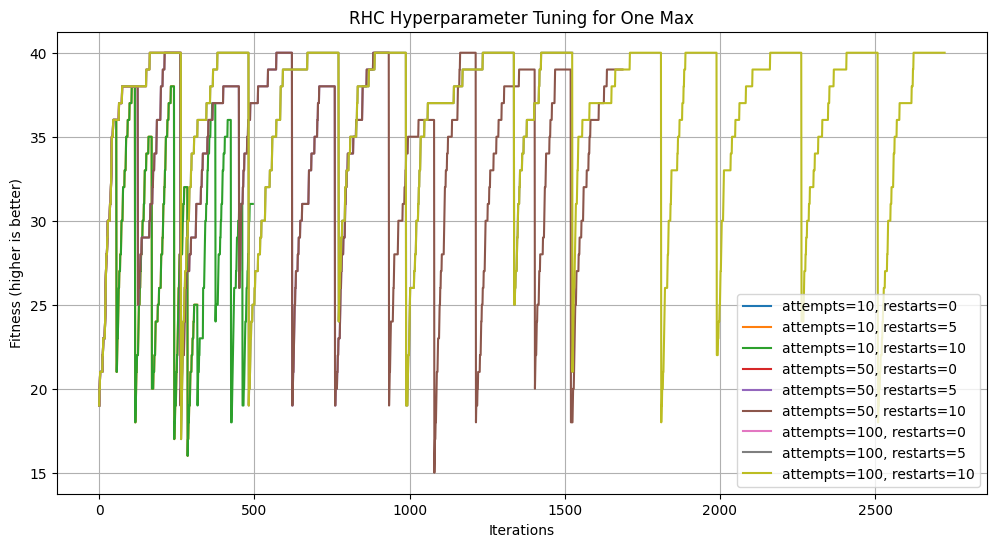

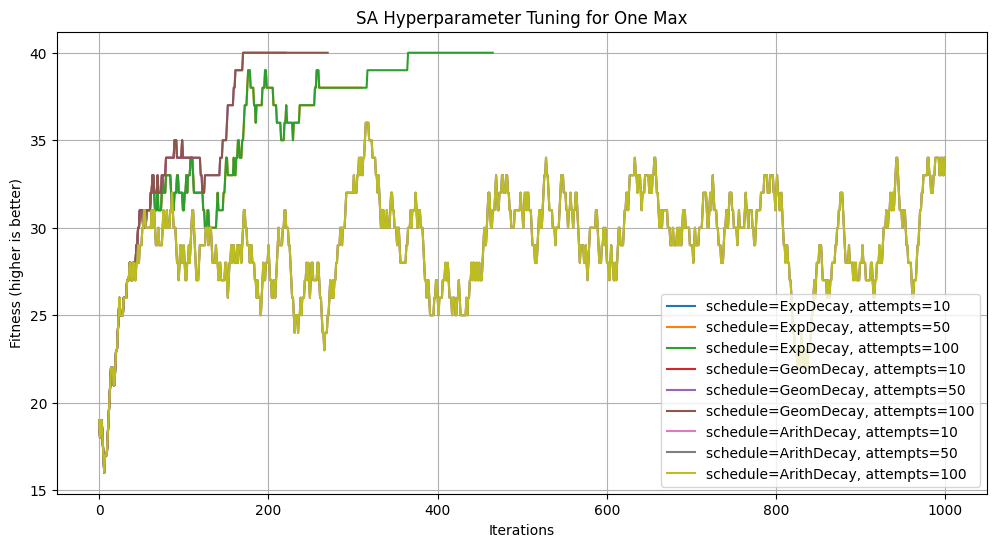

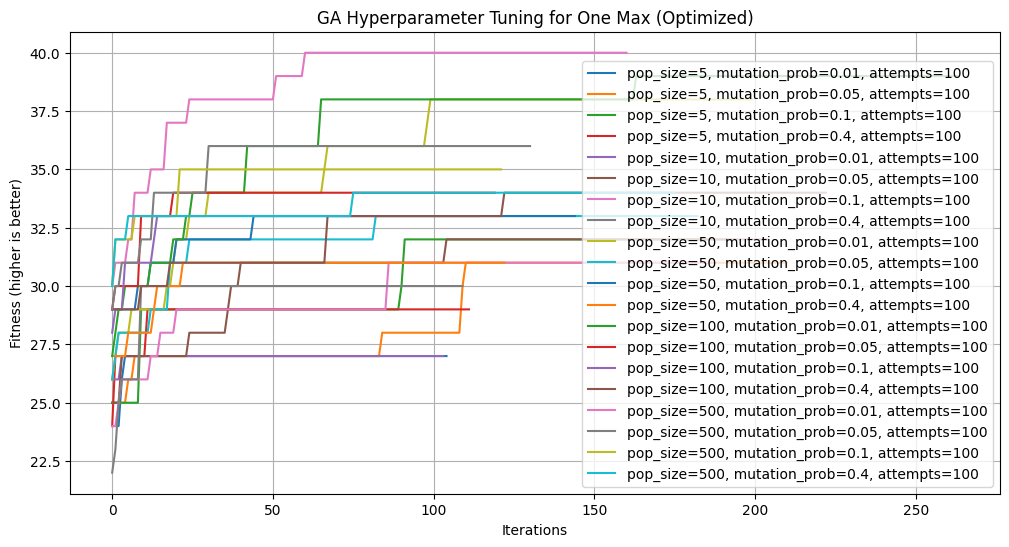

In [54]:
# Running the tuning and plotting for One Max problem
problem = setup_one_max(40)

# RHC tuning
rhc_results = tune_rhc(problem)
plot_rhc_tuning(rhc_results)

# SA tuning
sa_results = tune_sa(problem)
plot_sa_tuning(sa_results)

# GA tuning
ga_results = tune_ga(problem)
plot_ga_tuning(ga_results)

## Part 2: Train NN using Randomized Optimization

In [99]:
# !python3 -m pip install seaborn

In [100]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix

#### Read data and process it similar to the first assignment

In [81]:
df = pd.read_csv("data/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [83]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], how='all', inplace=True)
dfcopy = df.drop(columns=['customerID'], axis=1)

# Converting the target variable to integer
dfcopy['Churn'] = dfcopy['Churn'].apply(lambda x: 1 if x=='Yes' else 0)


# Identify categorical columns 
categorical_columns = dfcopy.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify binary columns (subset of categorical columns with only two unique values)
binary_columns = [col for col in categorical_columns if dfcopy[col].nunique() == 2]



# Label & One Hot Encoding Categorical Columns
label_encoder = LabelEncoder()
for col in binary_columns:
    dfcopy[col] = label_encoder.fit_transform(dfcopy[col])



categorical_columns = [col for col in categorical_columns if col not in binary_columns]
dfcopy = pd.get_dummies(dfcopy, columns=categorical_columns).astype(int)

# Monthly Charges and Total Charges can be log transformed to get onto a similar range
dfcopy['MonthlyCharges']=np.log1p(dfcopy['MonthlyCharges'])
dfcopy['TotalCharges']=np.log1p(dfcopy['TotalCharges'])


## Train Test Split
y = dfcopy['Churn'].values
X = dfcopy.drop(columns = ['Churn'])



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


In [90]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [95]:
### Params for Assignment 1

hidden_layer_sizes = [16]
learning_rate_init = 0.0001
alpha = 0.01


In [103]:
### Model Performance Evaluation 

#Accuracy, Precision, Recall, F1 and Confusion Matrix


def evaluate_model_performace(model,X_test,y_test):

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': round(accuracy,3),
        'precision': round(precision,3),
        'recall': round(recall,3),
        'f1': round(f1,3),
    }


#### Define the Neural Network and Optimization Problem

In [85]:
# Define the neural network using mlrose
nn_model = mlrose.NeuralNetwork(hidden_nodes=[16], activation='relu', 
                                algorithm='random_hill_climb', max_iters=1000,
                                bias=True, is_classifier=True, learning_rate=0.001,
                                early_stopping=True, clip_max=5, max_attempts=100, random_state=1)


In [113]:
# Define the neural network with Randomized Hill Climbing
nn_model_rhc = mlrose.NeuralNetwork(hidden_nodes=hidden_layer_sizes, activation='relu', 
                                          algorithm='random_hill_climb', max_iters=1000,
                                          bias=True, is_classifier=True, learning_rate=1,
                                          early_stopping=True, clip_max=5, max_attempts=100, random_state=1)

# Train using Randomized Hill Climbing
nn_model_rhc.fit(X_train, y_train)
y_train_pred_rhc = nn_model_rhc.predict(X_train)
y_test_pred_rhc = nn_model_rhc.predict(X_test)

train_accuracy_rhc = accuracy_score(y_train, y_train_pred_rhc)
test_accuracy_rhc = accuracy_score(y_test, y_test_pred_rhc)

print(f'RHC - Train accuracy: {train_accuracy_rhc}, Test accuracy: {test_accuracy_rhc}')

RHC - Train accuracy: 0.7746850873628607, Test accuracy: 0.7592417061611374


Accuracy: 0.7592
Precision: 0.5217
Recall: 0.4981
F1 Score: 0.5097


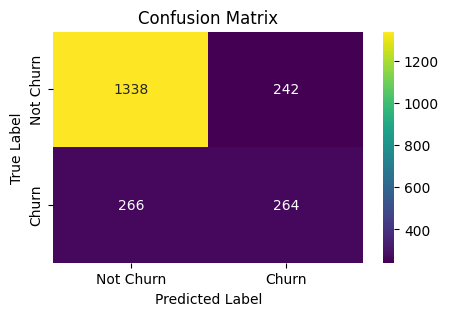

In [111]:
nn_rhc = evaluate_model_performace(nn_model_rhc,X_test,y_test)

In [109]:
# Define the neural network with Simulated Annealing
nn_model_sa = mlrose.NeuralNetwork(hidden_nodes=hidden_layer_sizes, activation='relu', 
                                         algorithm='simulated_annealing', max_iters=1000,
                                         bias=True, is_classifier=True, learning_rate=1,
                                         early_stopping=True, clip_max=5, max_attempts=100, random_state=1,
                                         schedule=mlrose.GeomDecay())

# Train using Simulated Annealing
nn_model_sa.fit(X_train, y_train)
y_train_pred_sa = nn_model_sa.predict(X_train)
y_test_pred_sa = nn_model_sa.predict(X_test)

train_accuracy_sa = accuracy_score(y_train, y_train_pred_sa)
test_accuracy_sa = accuracy_score(y_test, y_test_pred_sa)

print(f'SA - Train accuracy: {train_accuracy_sa}, Test accuracy: {test_accuracy_sa}')


SA - Train accuracy: 0.7192198293376676, Test accuracy: 0.7213270142180095


Accuracy: 0.7213
Precision: 0.4518
Recall: 0.5132
F1 Score: 0.4806


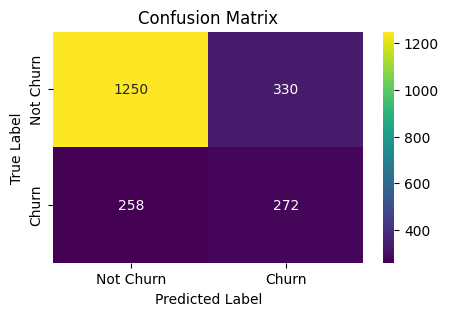

In [114]:
nn_sa = evaluate_model_performace(nn_model_sa,X_test,y_test)


In [120]:
# Define the neural network with Genetic Algorithm
nn_model_ga = mlrose.NeuralNetwork(hidden_nodes=hidden_layer_sizes, activation='relu', 
                                         algorithm='genetic_alg', max_iters=100,
                                         bias=True, is_classifier=True, learning_rate=1,
                                         early_stopping=True, clip_max=5, max_attempts=100, random_state=1,
                                         pop_size=500, mutation_prob=0.1)

# Train using Genetic Algorithm
nn_model_ga.fit(X_train, y_train)
y_train_pred_ga = nn_model_ga.predict(X_train)
y_test_pred_ga = nn_model_ga.predict(X_test)

train_accuracy_ga = accuracy_score(y_train, y_train_pred_ga)
test_accuracy_ga = accuracy_score(y_test, y_test_pred_ga)

print(f'GA - Train accuracy: {train_accuracy_ga}, Test accuracy: {test_accuracy_ga}')


/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/act

GA - Train accuracy: 0.7415684681023974, Test accuracy: 0.7549763033175355


Accuracy: 0.7550
Precision: 0.5238
Recall: 0.2698
F1 Score: 0.3562


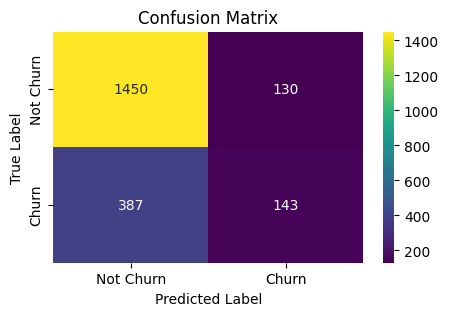

In [121]:
nn_ga = evaluate_model_performace(nn_model_ga,X_test,y_test)


In [118]:
# Compare with the MLPClassifier from sklearn
from sklearn.neural_network import MLPClassifier

mlp_best = MLPClassifier(solver='adam', 
                         alpha=alpha, 
                         hidden_layer_sizes=hidden_layer_sizes, 
                         learning_rate_init=learning_rate_init,
                         random_state=1, 
                         max_iter=1000)

mlp_best.fit(X_train, y_train)
y_train_pred_mlp = mlp_best.predict(X_train)
y_test_pred_mlp = mlp_best.predict(X_test)

train_accuracy_mlp = accuracy_score(y_train, y_train_pred_mlp)
test_accuracy_mlp = accuracy_score(y_test, y_test_pred_mlp)

print(f'MLP - Train accuracy: {train_accuracy_mlp}, Test accuracy: {test_accuracy_mlp}')

MLP - Train accuracy: 0.8061763510767981, Test accuracy: 0.8071090047393364


Accuracy: 0.8071
Precision: 0.6364
Recall: 0.5415
F1 Score: 0.5851


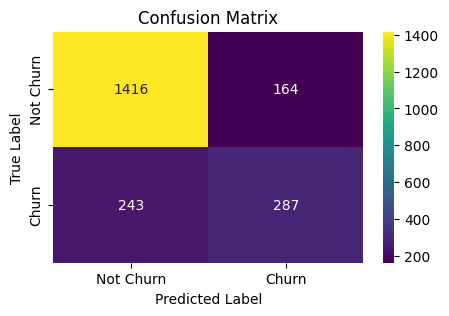

In [119]:
nn_gd = evaluate_model_performace(mlp_best,X_test,y_test)


#### Plot Validation Curves with nn_rhc, nn_sa and nn_ga for different learning rates, as during my tests, varying the learning rates caused major fluctuations in the model performance.

In [122]:
learning_rates = [0.01, 0.1, 1, 10]


In [123]:

def plot_validation_curve(learning_rates, train_scores, test_scores, title):
    plt.figure(figsize=(12, 6))
    plt.plot(learning_rates, train_scores, label='Train Accuracy', marker='o')
    plt.plot(learning_rates, test_scores, label='Test Accuracy', marker='o')
    plt.title(title)
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

train_scores_rhc = []
test_scores_rhc = []
train_scores_sa = []
test_scores_sa = []
train_scores_ga = []
test_scores_ga = []

/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/Users/nasharma/Library/Python/3.9/lib/python/site-packages/mlrose/act

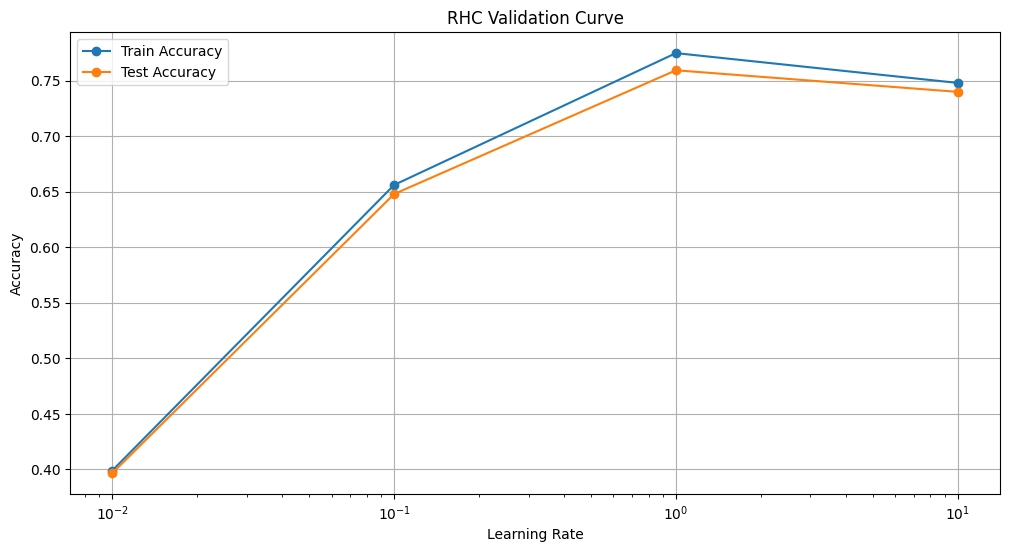

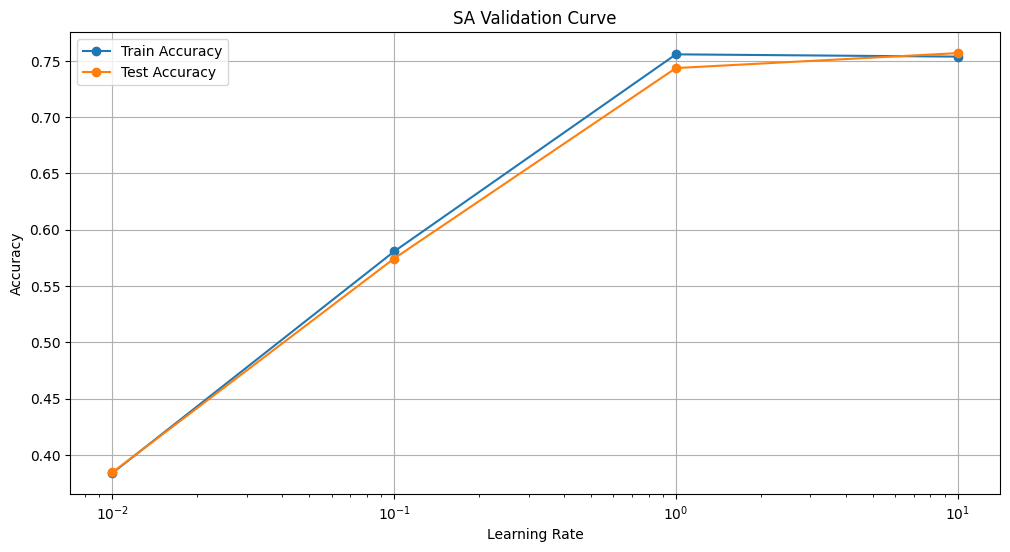

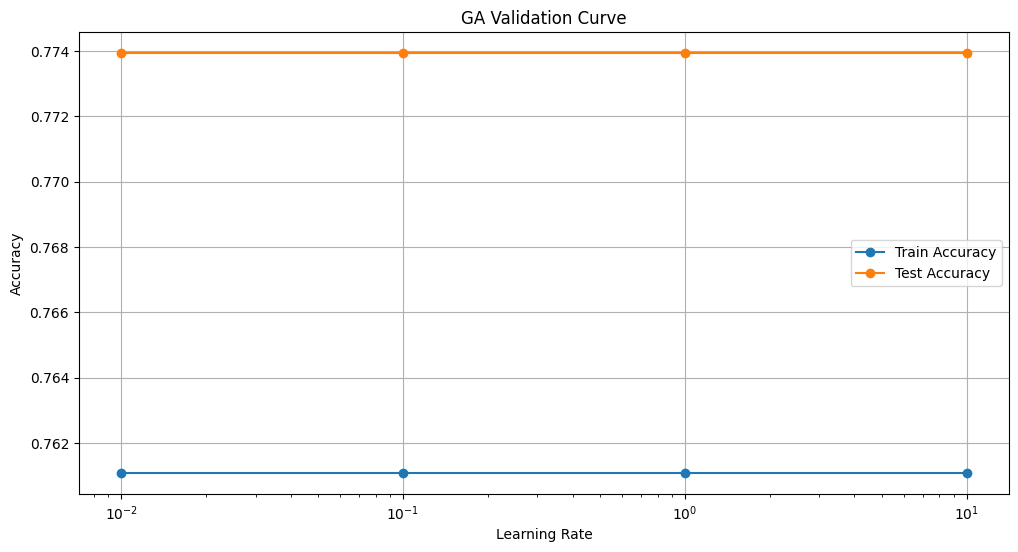

In [124]:
for lr in learning_rates:
    # Randomized Hill Climbing
    nn_model_rhc = mlrose.NeuralNetwork(hidden_nodes=hidden_layer_sizes, activation='relu', 
                                              algorithm='random_hill_climb', max_iters=1000,
                                              bias=True, is_classifier=True, learning_rate=lr,
                                              early_stopping=True, clip_max=5, max_attempts=100, random_state=1)

    nn_model_rhc.fit(X_train, y_train)
    y_train_pred_rhc = nn_model_rhc.predict(X_train)
    y_test_pred_rhc = nn_model_rhc.predict(X_test)

    train_accuracy_rhc = accuracy_score(y_train, y_train_pred_rhc)
    test_accuracy_rhc = accuracy_score(y_test, y_test_pred_rhc)
    train_scores_rhc.append(train_accuracy_rhc)
    test_scores_rhc.append(test_accuracy_rhc)

    # Simulated Annealing
    nn_model_sa = mlrose.NeuralNetwork(hidden_nodes=hidden_layer_sizes, activation='relu', 
                                             algorithm='simulated_annealing', max_iters=1000,
                                             bias=True, is_classifier=True, learning_rate=lr,
                                             early_stopping=True, clip_max=5, max_attempts=100, random_state=1,
                                             schedule=mlrose.GeomDecay())

    nn_model_sa.fit(X_train, y_train)
    y_train_pred_sa = nn_model_sa.predict(X_train)
    y_test_pred_sa = nn_model_sa.predict(X_test)

    train_accuracy_sa = accuracy_score(y_train, y_train_pred_sa)
    test_accuracy_sa = accuracy_score(y_test, y_test_pred_sa)
    train_scores_sa.append(train_accuracy_sa)
    test_scores_sa.append(test_accuracy_sa)

    # Genetic Algorithm
    nn_model_ga = mlrose.NeuralNetwork(hidden_nodes=hidden_layer_sizes, activation='relu', 
                                             algorithm='genetic_alg', max_iters=1000,
                                             bias=True, is_classifier=True, learning_rate=lr,
                                             early_stopping=True, clip_max=5, max_attempts=100, random_state=1,
                                             pop_size=500, mutation_prob=0.1)

    nn_model_ga.fit(X_train, y_train)
    y_train_pred_ga = nn_model_ga.predict(X_train)
    y_test_pred_ga = nn_model_ga.predict(X_test)

    train_accuracy_ga = accuracy_score(y_train, y_train_pred_ga)
    test_accuracy_ga = accuracy_score(y_test, y_test_pred_ga)
    train_scores_ga.append(train_accuracy_ga)
    test_scores_ga.append(test_accuracy_ga)

# Plot validation curves
plot_validation_curve(learning_rates, train_scores_rhc, test_scores_rhc, 'RHC Validation Curve')
plot_validation_curve(learning_rates, train_scores_sa, test_scores_sa, 'SA Validation Curve')
plot_validation_curve(learning_rates, train_scores_ga, test_scores_ga, 'GA Validation Curve')